In [1]:
### Importing all the neccessary packages ###
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from matplotlib.offsetbox import AnchoredText
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

import time 
from netCDF4 import Dataset, num2date, MFDataset
from tqdm import tqdm


In [2]:
from dask.distributed import Client
client = Client()

In [3]:
data_dir = '/data/deluge/observations/PRISM-Aardvark/'

In [4]:
ds = xr.open_mfdataset(data_dir+'PRISM_ppt_*',parallel=True,chunks={'latitude': 25, 'longitude': 25, 'time': -1})

In [ ]:
ds

In [55]:
subset=ds.sel(lat=slice(40,25), lon=slice(-105,-95), time=slice('1981-01-01','2019-01-01'))
data = subset.load()

In [57]:
data['time'] = pd.date_range('1981-01-01','2018-12-31',freq='1D')

In [27]:
def countWhiplashes(data,time,lower_percentile,higher_percentile):
    ### Set up for Pluvial to Drought ###

    numDaysToCheck = 11

    ts = pd.Series(data,index=time)

    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=30)
    rollingSum = ts.rolling(window=indexer, center=False).sum()
    whiplashData = pd.DataFrame(rollingSum)
    whiplashData.columns = ['vals']
    whiplashData['threshold'] = np.where(whiplashData.vals >= whiplashData.quantile(0.75)[0],2,1)
    whiplashData['threshold'] = np.where(whiplashData.vals <= whiplashData.quantile(0.25)[0],0,whiplashData.threshold)
    whiplashData['diff'] = whiplashData['threshold'] - whiplashData['threshold'].shift(-30)

    ### This compares diff to a shifted diff to get the last value in a series of values ###
    indexes = whiplashData[whiplashData['diff'].ne(whiplashData['diff'].shift(-1))]

    locs = indexes.index[indexes['diff'] == -2.0]

    ### Sums the preceeding 10 days. If they equal 22 then the its a drought period, if -22 then pluvial

    passTen = np.array([whiplashData.loc[:i].tail(numDaysToCheck)['threshold'].sum() for i in locs])



    ### Where these equal 22, then the the preceeding 10 days of whiplash were drought ###
    testlocs = locs[passTen==0.0]
    
    return len(testlocs)
    
    

In [58]:
%%time


test = xr.apply_ufunc(
    countWhiplashes,
    data['ppt'],
    data['time'],
    0.25,
    0.75,
    input_core_dims=[["time"],["time"],[],[]],
    exclude_dims=set(("time",)),
    #output_core_dims=[["counts"]],
    vectorize=True,
    dask = 'allowed',
    #output_sizes={"data_jday": 71},
)


CPU times: user 31min 27s, sys: 1min 44s, total: 33min 11s
Wall time: 30min 47s


In [59]:
test.to_netcdf('BryonyStudyArea.nc')

/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


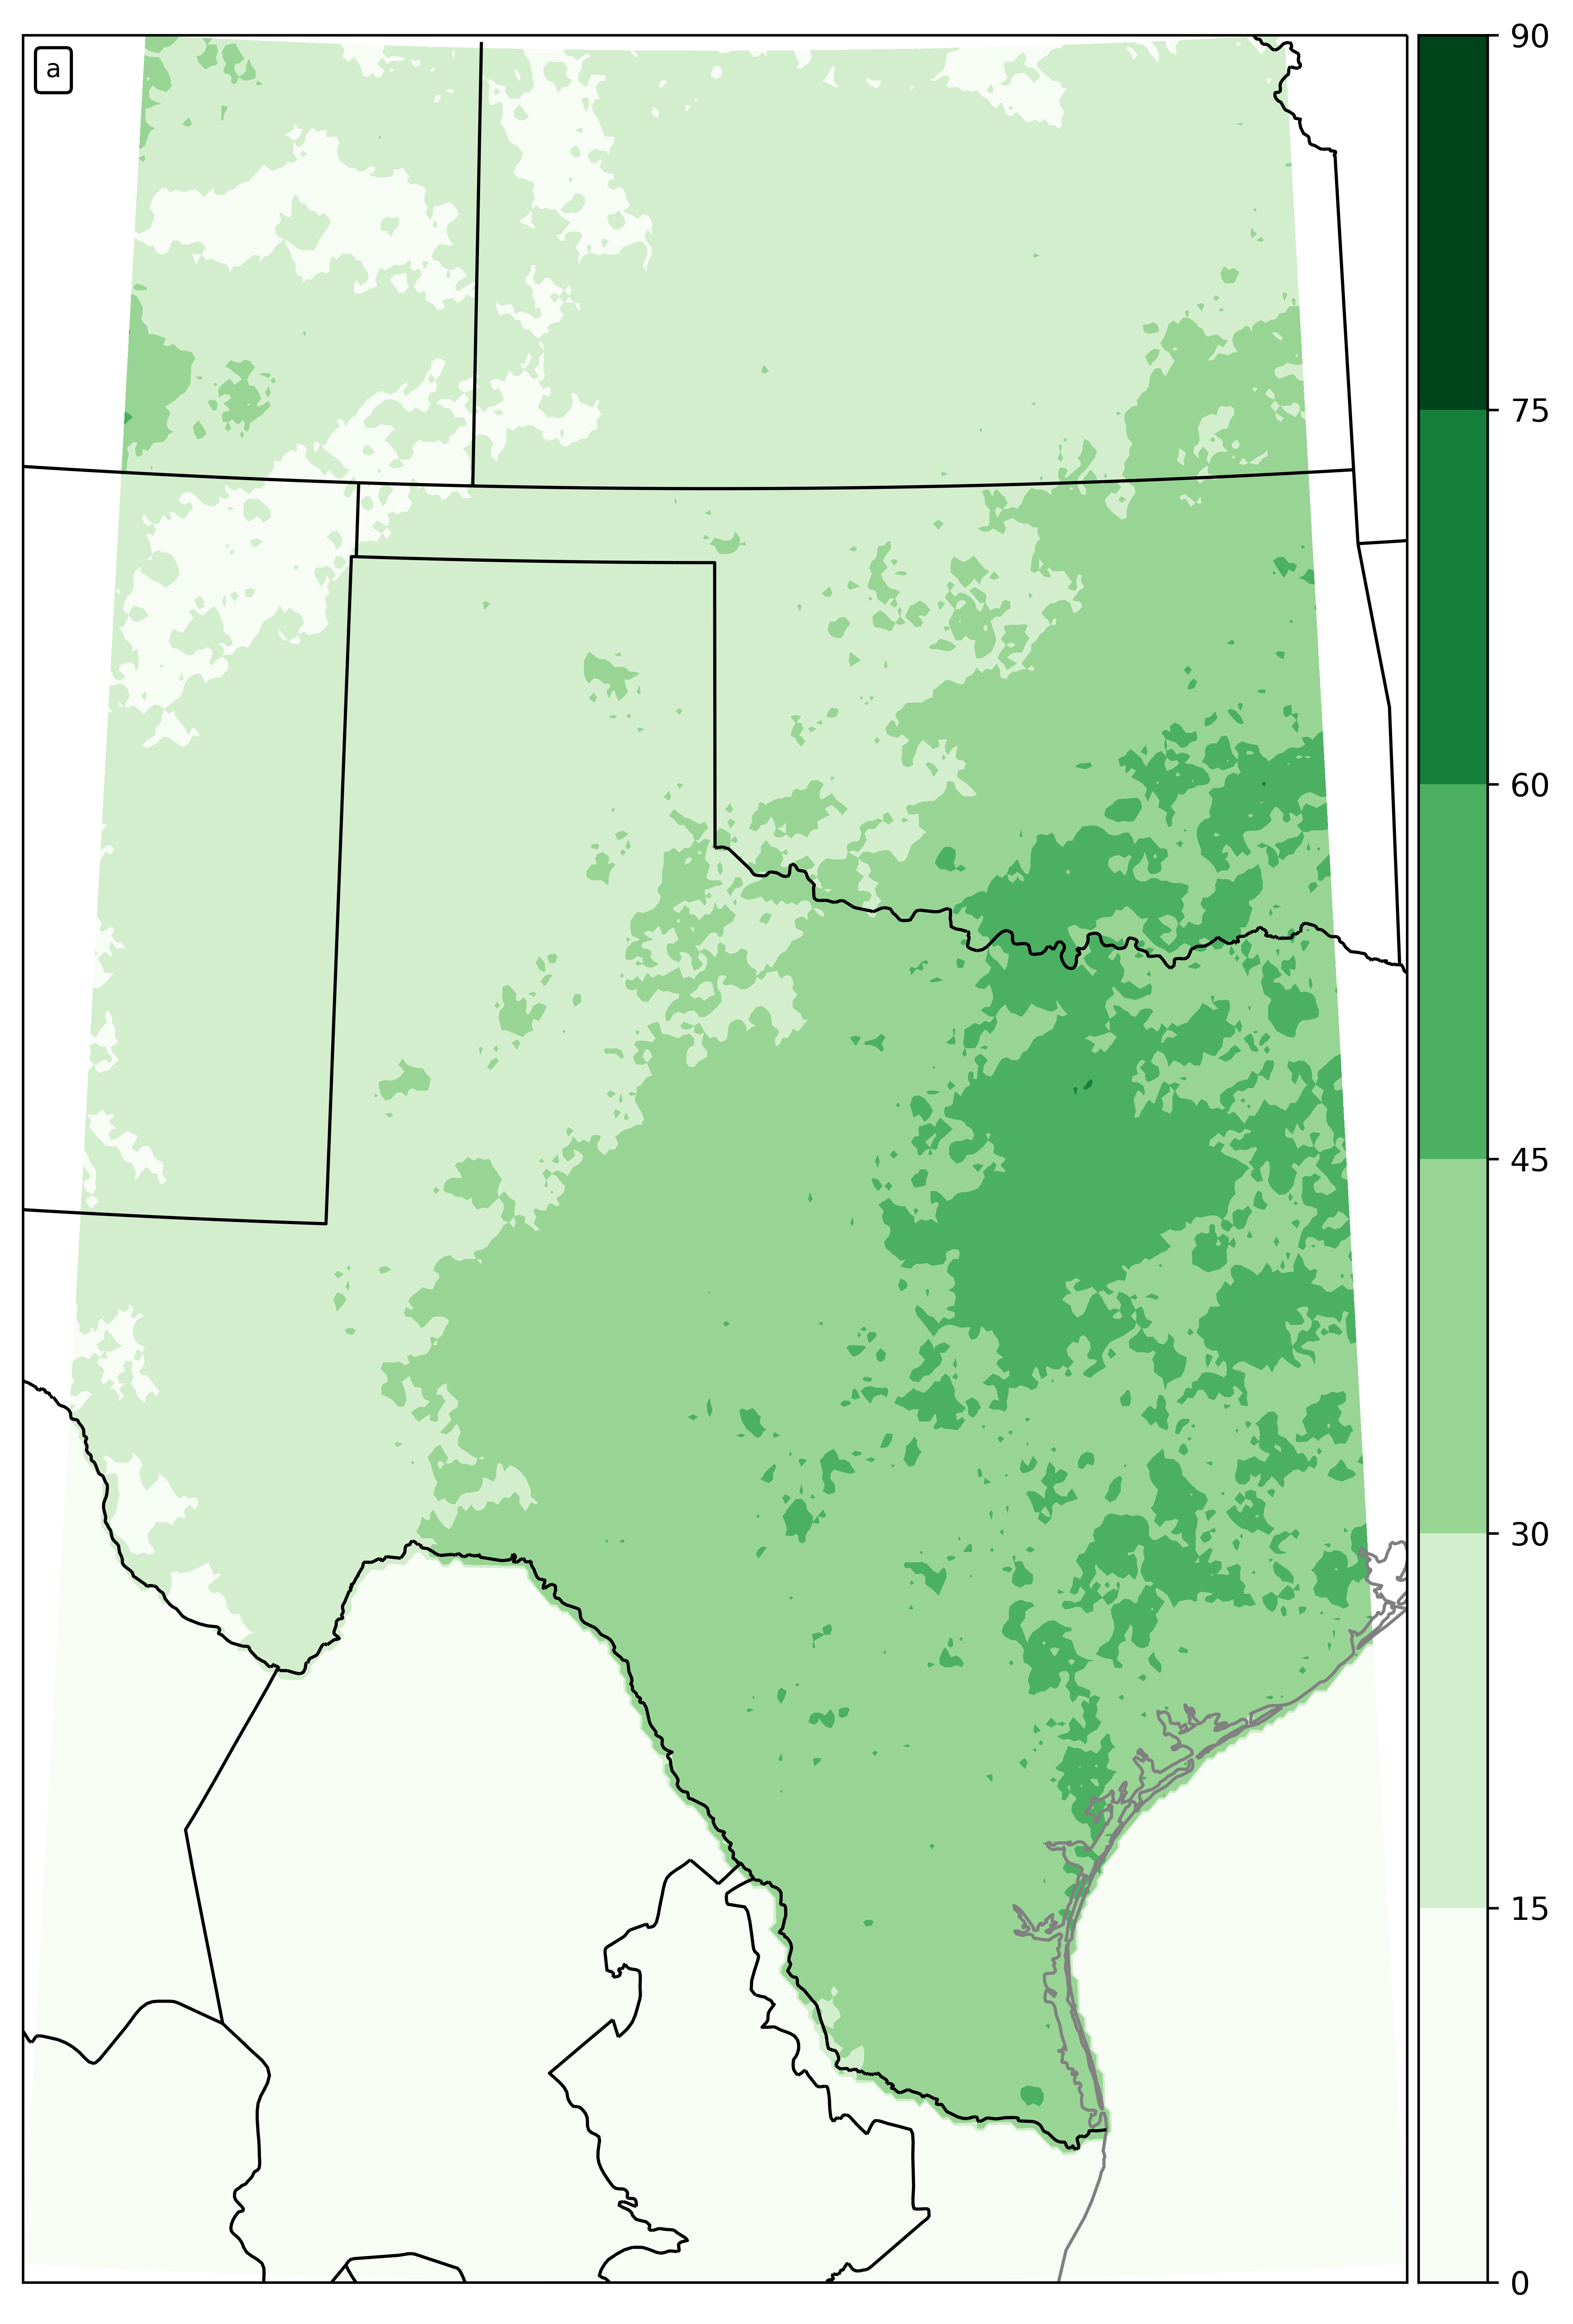

In [60]:
levs = np.arange(0,105,15)

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
map_proj = ccrs.LambertConformal(central_longitude=-100, central_latitude=45)
#cmap = mpl.cm.RdBu_r


f, ax1 = plt.subplots(1, 1, figsize=(10, 13), dpi=600, subplot_kw={'projection': map_proj})
p = test.plot.contourf(ax=ax1,transform=ccrs.PlateCarree(), add_colorbar=False, levels = levs, cmap='Greens')


### Setting 1st plot parameters ###
ax1.coastlines(color='grey')
ax1.add_feature(cartopy.feature.BORDERS, color='black')
ax1.add_feature(states_provinces, edgecolor='black')
#ax1.set_xticks(np.arange(-180,181, 40))
#ax1.set_yticks(np.arange(-90,91,15))
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
at = AnchoredText("a",
                      loc='upper left', prop=dict(size=8), frameon=True,)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
plt.colorbar(p, cax=cax)

In [31]:
%%time
### Set up for Pluvial to Drought ###

testData = data.sel(lon=-103.5, lat=39.1, method='nearest')

numDaysToCheck = 11

ts = pd.Series(testData['ppt'].values,index=testData.time)

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=30)
rollingSum = ts.rolling(window=indexer, center=False).sum()
whiplashData = pd.DataFrame(rollingSum)
whiplashData.columns = ['vals']
whiplashData['threshold'] = np.where(whiplashData.vals >= whiplashData.quantile(0.75)[0],2,1)
whiplashData['threshold'] = np.where(whiplashData.vals <= whiplashData.quantile(0.25)[0],0,whiplashData.threshold)
whiplashData['diff'] = whiplashData['threshold'] - whiplashData['threshold'].shift(-30)

### This compares diff to a shifted diff to get the last value in a series of values ###
indexes = whiplashData[whiplashData['diff'].ne(whiplashData['diff'].shift(-1))]

locs = indexes.index[indexes['diff'] == -2.0]

### Sums the preceeding 10 days. If they equal 22 then the its a drought period, if -22 then pluvial

passTen = np.array([whiplashData.loc[:i].tail(numDaysToCheck)['threshold'].sum() for i in locs])



### Where these equal 22, then the the preceeding 10 days of whiplash were drought ###
testlocs = locs[passTen==0.0]

CPU times: user 53.1 ms, sys: 9.91 ms, total: 63 ms
Wall time: 55.2 ms


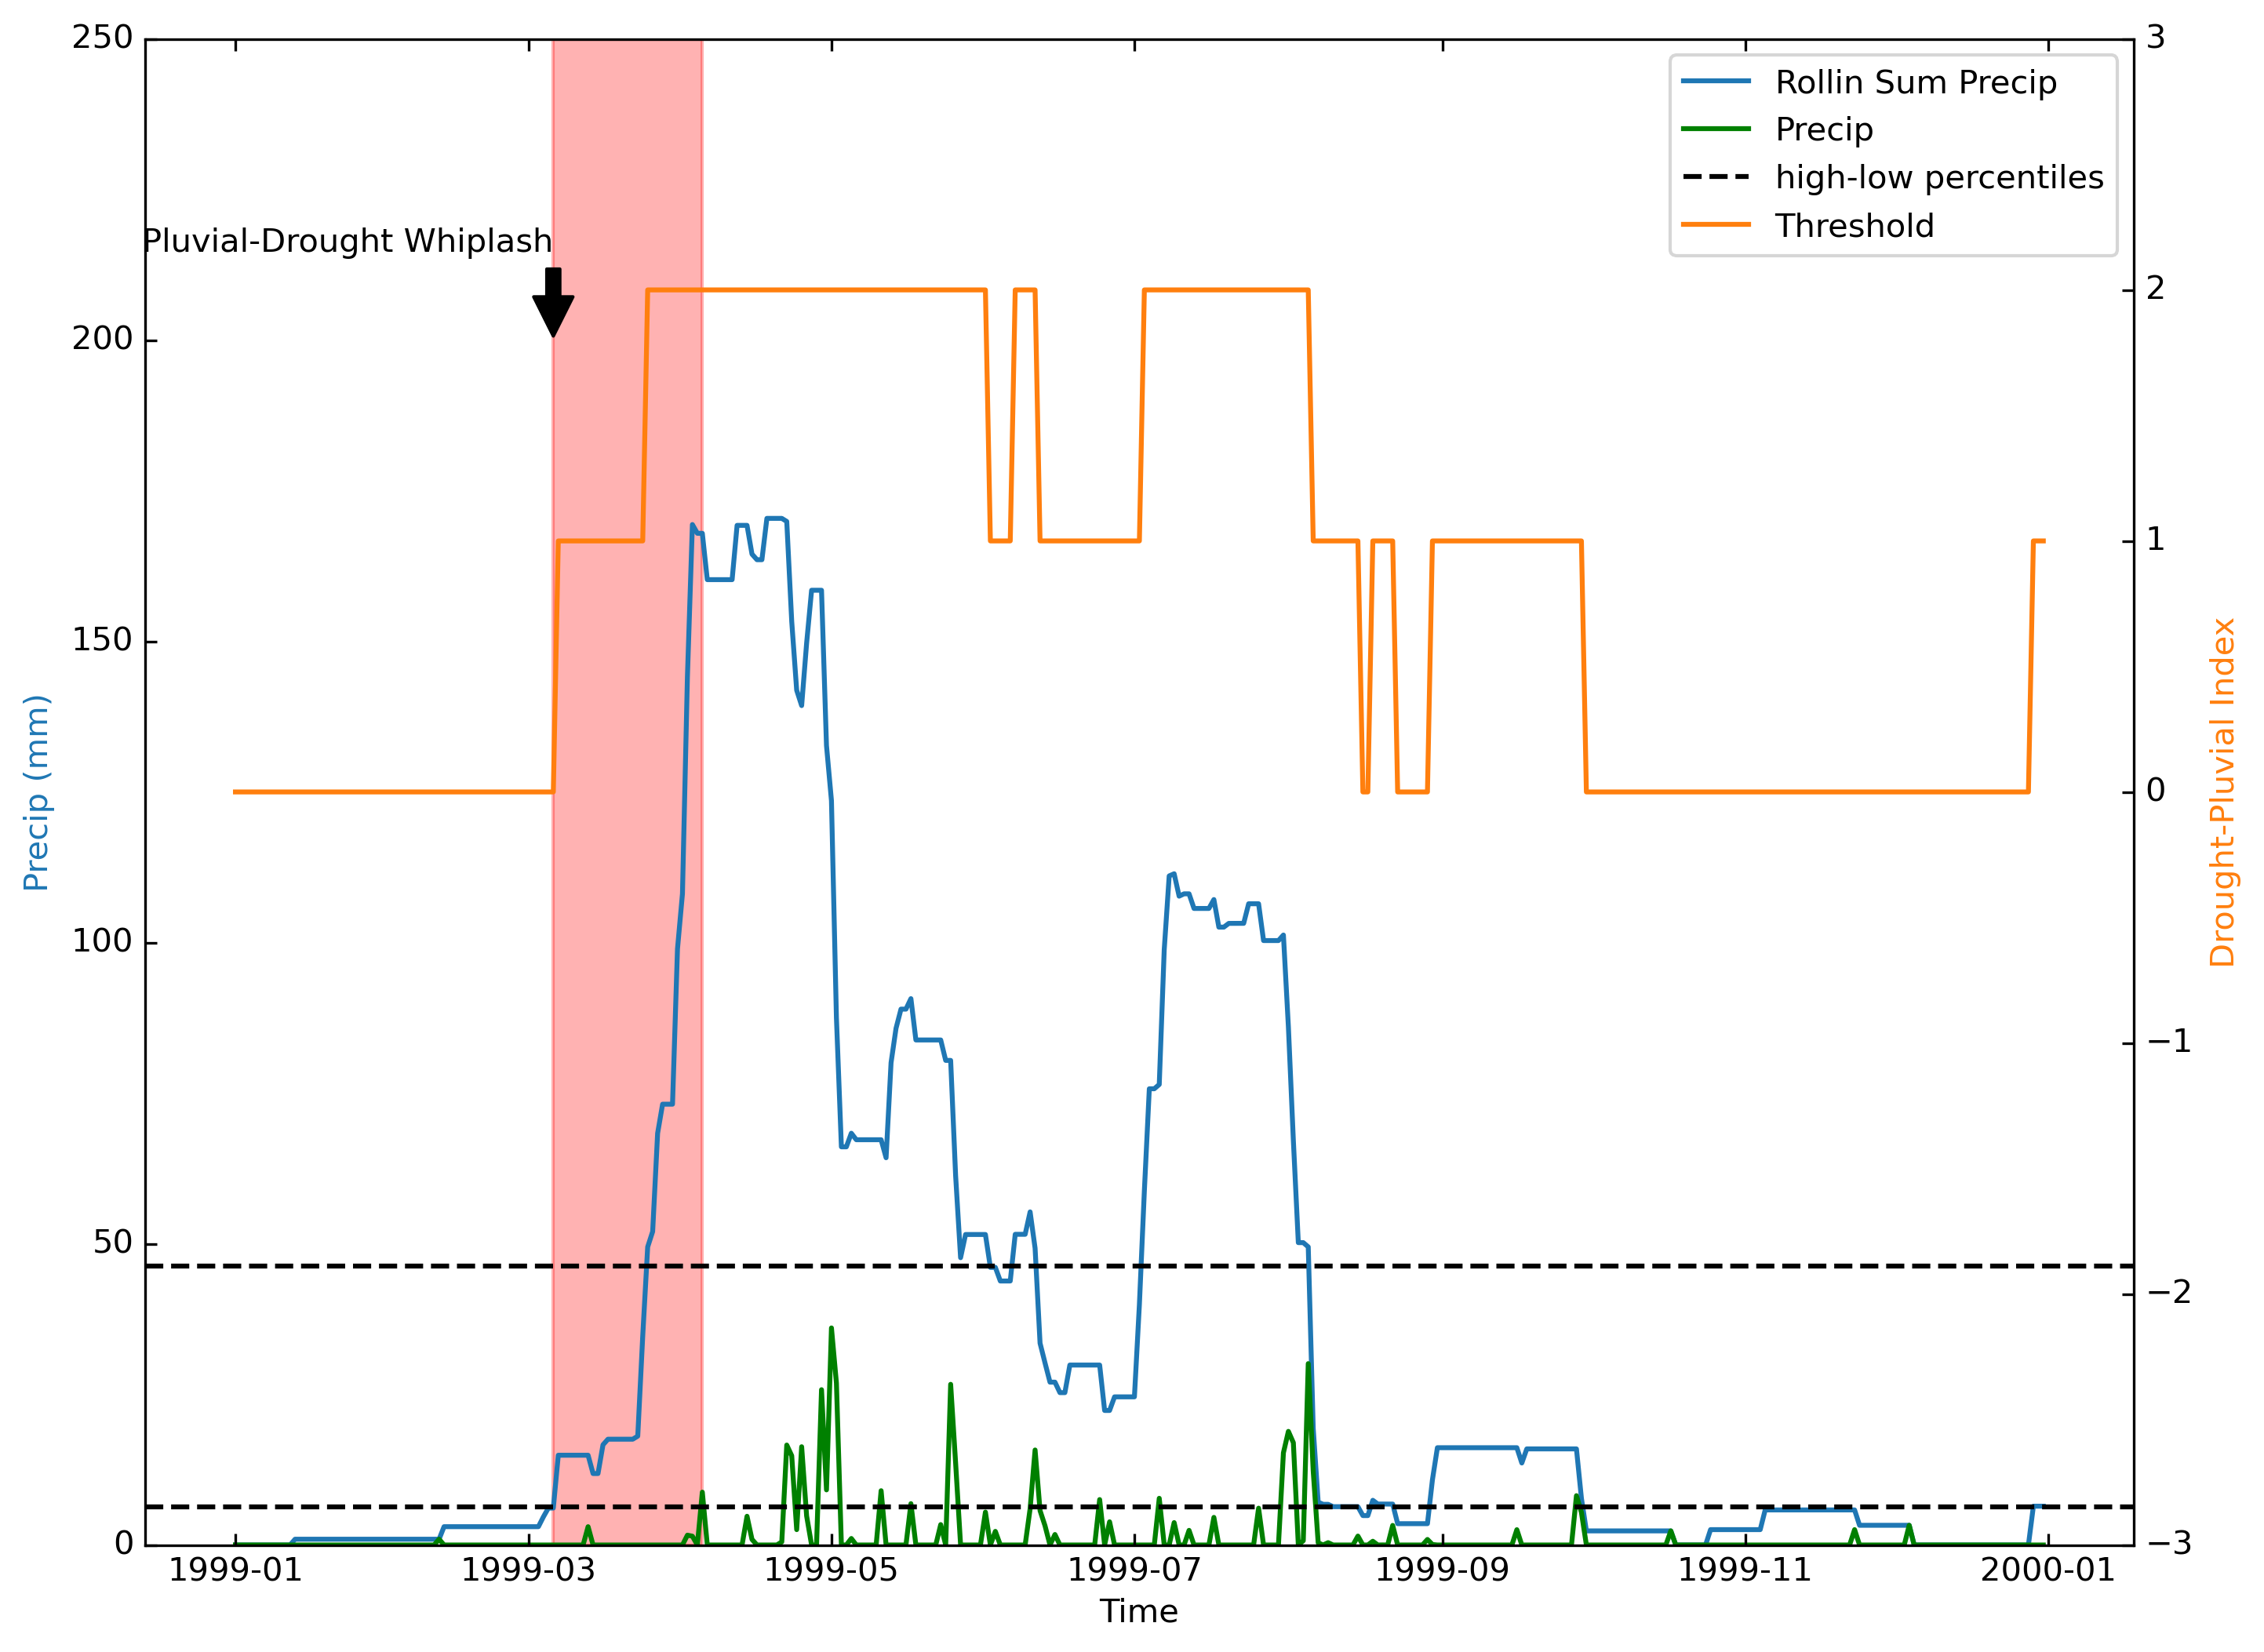

In [51]:
from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes
import matplotlib.pyplot as plt

start='1999-01-01'
end='1999-12-31'

whips = testlocs[testlocs.slice_indexer(start, end)]
plt.rcParams['figure.facecolor'] = 'white'

fig = plt.figure(figsize=(13, 8), dpi=300,)

host = fig.add_axes([0.15, 0.1, 0.65, 0.8], axes_class=HostAxes)
par1 = ParasiteAxes(host, sharex=host)

host.parasites.append(par1)


host.axis["right"].set_visible(False)

par1.axis["right"].set_visible(True)
par1.axis["right"].major_ticklabels.set_visible(True)
par1.axis["right"].label.set_visible(True)


host.set_ylim(0, 250)

host.set_xlabel("Time")
host.set_ylabel("Precip (mm)")
par1.set_ylabel("Drought-Pluvial Index")
#par2.set_ylabel("Velocity")

p1, = host.plot(whiplashData[start:end]['vals'], label="Rollin Sum Precip")
p4, = host.plot(ts[start:end], label="Precip", color='green')
p2, = par1.plot(whiplashData[start:end]['threshold'], label="Threshold")
#p3, = par1.plot(whiplashData[start:end]['diff'], label="diff", color='purple')

host.axhline(whiplashData.quantile(0.25)[0],color='black',linestyle='--',label='high-low percentiles')
host.axhline(whiplashData.quantile(0.75)[0],color='black',linestyle='--')

par1.set_ylim(-3, 3)
#par2.set_ylim(1, 65)
for i in whips:
    host.annotate('Pluvial-Drought Whiplash',
                xy=(i, 200), xycoords='data',
                xytext=(0, 25), textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='right', verticalalignment='bottom')
    host.axvspan(i, i + pd.DateOffset(days=30), color='red', alpha=0.3)

host.legend()


host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
#par2.axis["right"].label.set_color(p3.get_color())

plt.draw()
plt.show()

In [23]:
### Bryony's Method ###




def BryonyTransitions(data,time,percentile_low,percentile_high):
    #Reshape precip data to 2D array
    #PrecipData = np.reshape(PrecipData, [m,o*p], order = "F")
    
    ts = pd.Series(data,index=time)

    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=30)
    rollingSum = ts.rolling(window=indexer, center=False).sum()

    
    
    PrecipData = rollingSum.values
    #Find the percentiles in the precip data
    percentile_bottom = np.nanpercentile(PrecipData, percentile_low, 0)
    percentile_top = np.nanpercentile(PrecipData, percentile_high, 0)

    #Hard Code into 0s (drought months), 1s (average months), and 2s (wet months)
    precip_hardcode = np.empty_like(data)
    precip_hardcode[:]=np.nan

    for i in range(0,len(PrecipData)):
            if PrecipData[i]<=percentile_bottom:
                precip_hardcode[i]=0
            elif PrecipData[i]>=percentile_top:
                precip_hardcode[i]=2
            else:
                precip_hardcode[i]=1
    
    #Define and count transitions
    DPtotal=0 #no of DP transitions
    PDtotal=0 #no of PD transitions

    DPday = np.zeros_like(precip_hardcode)
    #DPcount=0 # count the no of DP transitions at each grid point
    #PDcount=0 # count the no of PD transitions at each grid point
    #DPday = [] # create an array to store the days at which DP transitions occur
    #PDday = [] # create an array to store the days at which PD transitions occur
    for i in range(0, len(precip_hardcode)-31): #loop through entire time period up until the last 30 days
        #if all days are in drought conditions for all 10 days before the current day at said grid point and the difference between now and 30 days from now is -2 (drought to pluvial) and the next day does not equal -2 I.E. its the last transition day count as DP transition
        if all([i == 0 for i in precip_hardcode[i-10:i]]) and precip_hardcode[i] - precip_hardcode[i+30] == -2 and precip_hardcode[i+1] - precip_hardcode[i+31] != -2:
            #DPcount = DPcount+1
            DPtotal = DPtotal+1
            DPday[i]=1
        #if all days are in pluvial conditions for all 10 days before the current day at said grid point and the difference between now and 30 days from now is 2 (pluvial to drought) and the next day does not equal 2 I.E. its the last transition day count as PD transition
        elif all([i == 2 for i in precip_hardcode[i-10:i]]) and precip_hardcode[i] - precip_hardcode[i+30] == 2  and precip_hardcode[i+1] - precip_hardcode[i+31] != 2: #Pluvial to Drought i.e 2 month to 0 month
            #PDcount = PDcount+1
            PDtotal = PDtotal+1
            
            #PDday = np.append(PDday, i)
        else:
            pass

    return(DPtotal)


In [24]:
%%time
test2 = xr.apply_ufunc(
    BryonyTransitions,
    data['ppt'],
    data['time'],
    25,
    75,
    input_core_dims=[["time"],["time"],[],[]],
    exclude_dims=set(("time",)),
    #output_core_dims=[["counts"]],
    vectorize=True,
    dask = 'parallelized',
    #output_sizes={"data_jday": 71},
)


CPU times: user 5min 53s, sys: 5.82 s, total: 5min 59s
Wall time: 5min 53s
